# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [ ]:
# ==== General Purpose ====
import os
import json
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== Suppress Warnings ====
warnings.filterwarnings('ignore')

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split

# ==== TensorFlow Core ====
import tensorflow as tf
from tensorflow import keras

# ==== TensorFlow - Layers ====
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense,
    Bidirectional, LSTM, TextVectorization
)

# ==== TensorFlow - Callbacks ====
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# ==== TensorFlow - Optimizers & Metrics ====
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


In [ ]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing

Warning: running the following cell can take some time.


In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


In [ ]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
# csv_loc = '/content/IMDB_overview_genres.csv'

dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [ ]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [ ]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):
    # Decode and resize the image
    image = tf.image.resize(image, [64, 64])  # Resize to 64x64 pixels
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to range [0, 1]

    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.


# Define the batch size
BATCH_SIZE = 64

# Function to resize and normalize images for vectorization (works with both image and label)
def img_process(image, label):
    # Resize and normalize image
    image = tf.image.resize(image, [64, 64])  # Resize images to 64x64 pixels
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Parse_image function for compatibility with the pipeline
def parse_image(filename, label):
    image = tf.io.read_file(filename)  # Read image file
    image = tf.io.decode_jpeg(image, channels=3)  # Decode JPEG into a tensor
    return image, label

# Construct efficient dataset pipeline for training
posters_train_ds = (
    list_posters_train_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Read and decode images
    .batch(BATCH_SIZE)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Apply img_process (resize and normalize)
    .shuffle(buffer_size=1000)  # Shuffle the dataset
    .cache()  # Cache the dataset for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch data for better performance
)

# Construct efficient dataset pipeline for validation
posters_valid_ds = (
    list_posters_valid_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Read and decode images
    .batch(BATCH_SIZE)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Apply img_process (resize and normalize)
    .cache()  # Cache the dataset for faster access
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch data for better performance
)

### 1.b. Natural Language processing of the overviews

In [ ]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [ ]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.



# Define the batch size
BATCH_SIZE = 64  # Batch size explicitly set as 64

# Tokenizer for text preprocessing
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='int',output_sequence_length=100)

# Adapt the tokenizer to the training data
tokenizer.adapt(overviews_train)

# Function to tokenize and preprocess text data
def text_process(text, label):
    text = tokenizer(text)  # Tokenize the text into integer sequences
    return text, label

# Construct the training dataset with explicit batch size assignment
overviews_train_ds = list_overviews_train_ds.map(text_process, num_parallel_calls=tf.data.AUTOTUNE)
overviews_train_ds = overviews_train_ds.shuffle(1000)  # Shuffle for randomness
overviews_train_ds = overviews_train_ds.batch(BATCH_SIZE)  # Explicitly batch data
overviews_train_ds = overviews_train_ds.cache()  # Cache the dataset for faster loading
overviews_train_ds = overviews_train_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance

# Construct the validation dataset with explicit batch size assignment
overviews_valid_ds = list_overviews_valid_ds.map(text_process, num_parallel_calls=tf.data.AUTOTUNE)
overviews_valid_ds = overviews_valid_ds.batch(BATCH_SIZE)  # Explicitly batch data
overviews_valid_ds = overviews_valid_ds.cache()  # Cache the dataset for faster access
overviews_valid_ds = overviews_valid_ds.prefetch(tf.data.AUTOTUNE)  # Prefetch for performance

# Debugging - Confirm batch size explicitly
for data, labels in overviews_train_ds.take(1):
    print("Training batch size:", data.shape[0])  # Should print 64
    assert data.shape[0] == BATCH_SIZE, "Training dataset batch size is incorrect."

for data, labels in overviews_valid_ds.take(1):
    print("Validation batch size:", data.shape[0])  # Should print 64
    assert data.shape[0] == BATCH_SIZE, "Validation dataset batch size is incorrect."


Training batch size: 64
Validation batch size: 64


* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [ ]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000  # Set the vocabulary size

# Initialize the TextVectorization layer
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,output_sequence_length=100)

# Adapt the encoder to the training data to build the vocabulary
encoder.adapt(overviews_train)

* Print the first 200 words of the vocabulary you obtained.

In [ ]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

# Retrieve the vocabulary from the encoder
vocabulary = encoder.get_vocabulary()

# Print the first 200 words
print(vocabulary[:200])

['', '[UNK]', np.str_('a'), np.str_('the'), np.str_('to'), np.str_('of'), np.str_('and'), np.str_('in'), np.str_('his'), np.str_('is'), np.str_('an'), np.str_('with'), np.str_('her'), np.str_('for'), np.str_('on'), np.str_('he'), np.str_('their'), np.str_('who'), np.str_('by'), np.str_('from'), np.str_('when'), np.str_('as'), np.str_('that'), np.str_('after'), np.str_('young'), np.str_('life'), np.str_('they'), np.str_('man'), np.str_('two'), np.str_('at'), np.str_('him'), np.str_('new'), np.str_('but'), np.str_('are'), np.str_('into'), np.str_('up'), np.str_('has'), np.str_('she'), np.str_('woman'), np.str_('out'), np.str_('family'), np.str_('love'), np.str_('one'), np.str_('find'), np.str_('must'), np.str_('finds'), np.str_('it'), np.str_('friends'), np.str_('be'), np.str_('world'), np.str_('story'), np.str_('school'), np.str_('them'), np.str_('where'), np.str_('while'), np.str_('about'), np.str_('group'), np.str_('have'), np.str_('lives'), np.str_('wife'), np.str_('girl'), np.str_('

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():
    # Input layer
    inputs = layers.Input(shape=(64, 64, 3), name="Input")

    # Conv0
    x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same", activation="relu", name="Conv0")(inputs)
    x = layers.Dropout(0.2, name="Drop1")(x)

    # Conv1 and Conv2
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv1")(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv2")(x)
    x = layers.Dropout(0.2, name="Drop2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    # Conv3 and Conv4
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv3")(x)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv4")(x)
    x = layers.Dropout(0.2, name="Drop3")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool2")(x)

    # Conv5 and Conv6
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv5")(x)
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv6")(x)
    x = layers.Dropout(0.2, name="Drop4")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool3")(x)

    # Flatten and Dense layers
    x = layers.Flatten(name="Flat")(x)
    x = layers.Dense(1024, activation="relu", name="FC1")(x)
    x = layers.Dropout(0.5, name="Drop5")(x)
    x = layers.Dense(1024, activation="relu", name="FC2")(x)
    x = layers.Dropout(0.5, name="Drop6")(x)

    # Output layer
    outputs = layers.Dense(25, activation="sigmoid", name="Output")(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_Model")

    return model

# Instantiate the model
cnn_model = build_cnn_model()

* Print the model summary and confirm it has the same architecture as the one provided.

In [ ]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

#Complete here
cnn_model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv0 (Conv2D)                  │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop2 (Dropout)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop3 (Dropout)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv6 (Conv2D)                  │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop4 (Dropout)                 │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flat (Flatten)                  │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop5 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop6 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 25)             │        25,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])


### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [ ]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

embedder = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=256,mask_zero=True,name="EmbeddingLayer")

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [ ]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.



lstm_model = tf.keras.Sequential([encoder,embedder,
    Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True),name="BiLSTM1"),
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2),name="BiLSTM2"),
    Dense(128, activation="relu", name="Dense1"),  # Dense layer with 128 units and ReLU
    Dropout(0.8, name="Dropout1"),  # Dropout layer with rate 0.8
    Dense(25, activation="sigmoid", name="Output")])

# Build the model by specifying the input shape
lstm_model.build(input_shape=(None, 100))



* Print the model summary and confirm is has the same architecture as the outline provided above.

In [ ]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

#Complete here
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ EmbeddingLayer (Embedding)      │ (None, 100, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM1 (Bidirectional)         │ (None, 100, 512)       │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM2 (Bidirectional)         │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [ ]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])


# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [ ]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'


# Checkpoint callback for the CNN model
checkpoint_cnn_callback = ModelCheckpoint(filepath=checkpoint_cnn_filepath,monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)


# Checkpoint callback for the LSTM model
checkpoint_lstm_callback = ModelCheckpoint(filepath=checkpoint_lstm_filepath,monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"



# Provided scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(schedule=scheduler, verbose=1)


### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3a-iii
### Train the CNN model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.



# Load the dataset
csv_loc = '/content/IMDB_overview_genres.csv'  # Path to your dataset
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = train_test_split(dataset, test_size=0.2, random_state=42)

# Define the path to the directory containing the images
img_loc = "/content/drive/MyDrive/Images"  # Update this path as necessary

# Generate full file paths for training and testing image datasets
img_locs_train = np.array([img_loc + '/' + id + '.jpg' for id in data_train['Id']])
img_locs_test = np.array([img_loc + '/' + id + '.jpg' for id in data_test['Id']])

# Prepare labels for training and testing
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'], axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'], axis=1)).astype('float32')

# Create TensorFlow datasets
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train, labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test, labels_test))

# Define the parse_image function
def parse_image(filename, label):
    filename = filename.numpy().decode('utf-8')  # Convert tf.Tensor to Python string
    if tf.io.gfile.exists(filename):  # Check if the file exists
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image, channels=3)  # Decode with 3 channels (RGB)
        image = tf.cast(image, tf.float32)  # Cast image to float32
        return image, label
    else:
        print(f"File not found: {filename}")  # Log missing files
        return tf.zeros((64, 64, 3), dtype=tf.float32), label  # Return a blank float32 image

# Wrap parse_image for TensorFlow Dataset
def parse_image_py_function(filename, label):
    image, label = tf.py_function(parse_image, [filename, label], [tf.float32, tf.float32])
    image.set_shape([None, None, 3])  # Set shape of image tensor
    label.set_shape([labels_train.shape[1]])  # Set shape of label tensor
    return image, label

# Define the image processing function
def img_process(image, label):
    image = tf.image.resize(image, [64, 64])  # Resize images to 64x64
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply parsing and processing to the datasets
BATCH_SIZE = 64
posters_train_ds = (list_posters_train_ds.map(parse_image_py_function, num_parallel_calls=tf.data.AUTOTUNE).map(img_process, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE))

posters_valid_ds = (list_posters_valid_ds.map(parse_image_py_function, num_parallel_calls=tf.data.AUTOTUNE).map(img_process, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE))

# Define the CNN model
def build_cnn_model():
    inputs = layers.Input(shape=(64, 64, 3), name="Input")
    x = layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same", activation="relu", name="Conv0")(inputs)
    x = layers.Dropout(0.2, name="Drop1")(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv1")(x)
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu", name="Conv2")(x)
    x = layers.Dropout(0.2, name="Drop2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)
    x = layers.Flatten(name="Flat")(x)
    x = layers.Dense(1024, activation="relu", name="FC1")(x)
    outputs = layers.Dense(25, activation="sigmoid", name="Output")(x)
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_Model")
    return model

# Build and compile the CNN model
cnn_model = build_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(), Recall()])

# Define the checkpoint callback for the CNN model
checkpoint_cnn_callback = ModelCheckpoint(filepath='/content/checkpoint_cnn.weights.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)

# Define the learning rate scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure the learning rate is a Python float
    else:
        return float(lr * tf.math.exp(-0.01).numpy())  # Convert tensor to float

lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Train the CNN model
cnn_history = cnn_model.fit(posters_train_ds,validation_data=posters_valid_ds,epochs=40,callbacks=[checkpoint_cnn_callback, lr_callback],verbose=1)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 0.3312 - precision_1: 0.3386 - recall_1: 0.2309 
Epoch 1: val_loss improved from inf to 0.25350, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 1292s 14s/step - loss: 0.3304 - precision_1: 0.3399 - recall_1: 0.2310 - val_loss: 0.2535 - val_precision_1: 0.5540 - val_recall_1: 0.3316 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.2365 - precision_1: 0.5777 - recall_1: 0.2433
Epoch 2: val_loss improved from 0.25350 to 0.25244, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 88s 454ms/step - loss: 0.2365 - precision_1: 0.5777 - recall_1: 0.2435 - val_loss: 0.2524 - val_precision_1: 0.5371 - val_recall_1: 0.3551 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler set

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3b-i

# Extract text data and labels
overviews_train = data_train['Overview'].values  # Training text data
overviews_test = data_test['Overview'].values  # Testing text data

# Initialize TextVectorization layer
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=100)

# Adapt the vectorizer to the training text data
vectorizer.adapt(overviews_train)

# Vectorize the text data
tokenized_train = vectorizer(overviews_train)
tokenized_test = vectorizer(overviews_test)

# Create TensorFlow datasets
overviews_train_ds = tf.data.Dataset.from_tensor_slices((tokenized_train, labels_train)).batch(64).prefetch(tf.data.AUTOTUNE)
overviews_valid_ds = tf.data.Dataset.from_tensor_slices((tokenized_test, labels_test)).batch(64).prefetch(tf.data.AUTOTUNE)

# Define the LSTM model
def build_lstm_model(vocab_size, embed_dim, output_dim):
    model = Sequential([layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True, name="Embedding"),layers.Bidirectional(layers.LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True), name="BiLSTM1"),layers.Bidirectional(layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2), name="BiLSTM2"),layers.Dense(128, activation="relu", name="Dense1"),layers.Dropout(0.8, name="Dropout1"),layers.Dense(output_dim, activation="sigmoid", name="Output")])
    return model

# Parameters for the LSTM model
VOCAB_SIZE = 10000  # Vocabulary size for text tokenization
EMBED_DIM = 256     # Embedding dimensions
OUTPUT_DIM = 25     # Number of output labels (genres)

# Build and compile the LSTM model
lstm_model = build_lstm_model(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, output_dim=OUTPUT_DIM)

lstm_model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[Precision(name="precision"), Recall(name="recall")])

# Print the LSTM model summary
lstm_model.summary()

# Define callbacks
checkpoint_lstm_callback = ModelCheckpoint(filepath='/content/checkpoint_lstm.weights.h5',monitor='val_loss',save_best_only=True,save_weights_only=True,mode='min',verbose=1)

# Updated scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Ensure it is returned as a Python float
    else:
        return float(lr * tf.math.exp(-0.01))  # Ensure result is a Python float

lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Train the LSTM model for 20 epochs
lstm_history = lstm_model.fit(overviews_train_ds,validation_data=overviews_valid_ds,epochs=20,callbacks=[checkpoint_lstm_callback, lr_callback],verbose=1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM1 (Bidirectional)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM2 (Bidirectional)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.6596 - precision: 0.1044 - recall: 0.3588
Epoch 1: val_loss improved from inf to 0.34007, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - loss: 0.6588 - precision: 0.1046 - recall: 0.3582 - val_loss: 0.3401 - val_precision: 0.5415 - val_recall: 0.2271 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.4620 - precision: 0.1746 - recall: 0.2954
Epoch 2: val_loss improved from 0.34007 to 0.29230, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - loss: 0.4618 - precision: 0.1746 - recall: 0.2952 - val_loss: 0.2923 - val_precision: 0.5415 - val_recall: 0.2271 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.9999997

In [ ]:
# # Save training history
# with open('/content/lstm_history.json', 'w') as f:
#     json.dump(lstm_history.history, f)


# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


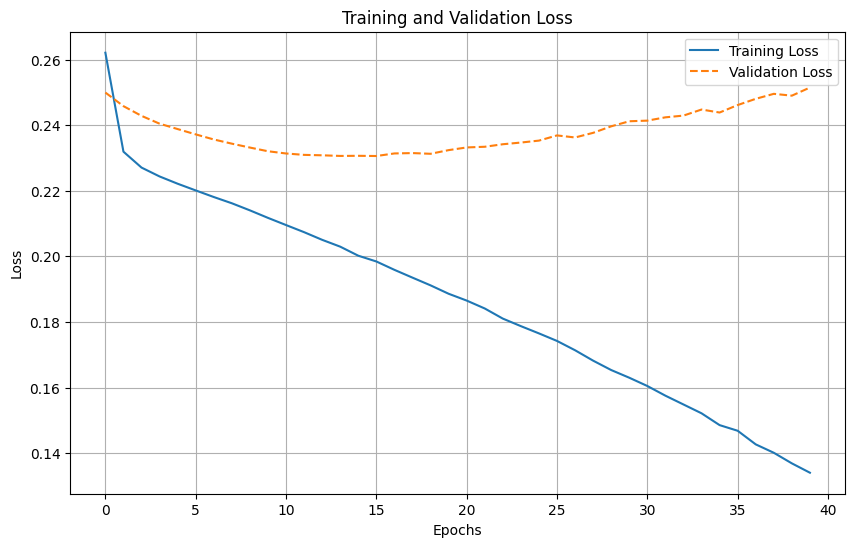

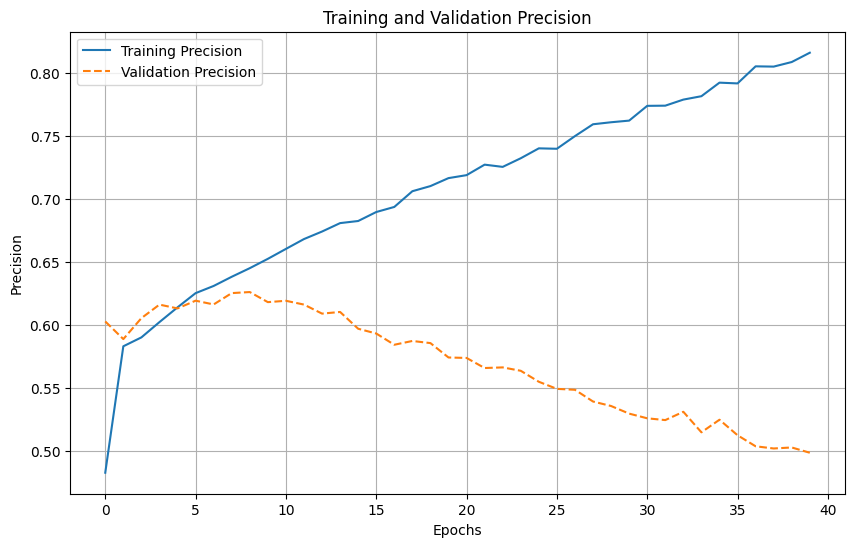

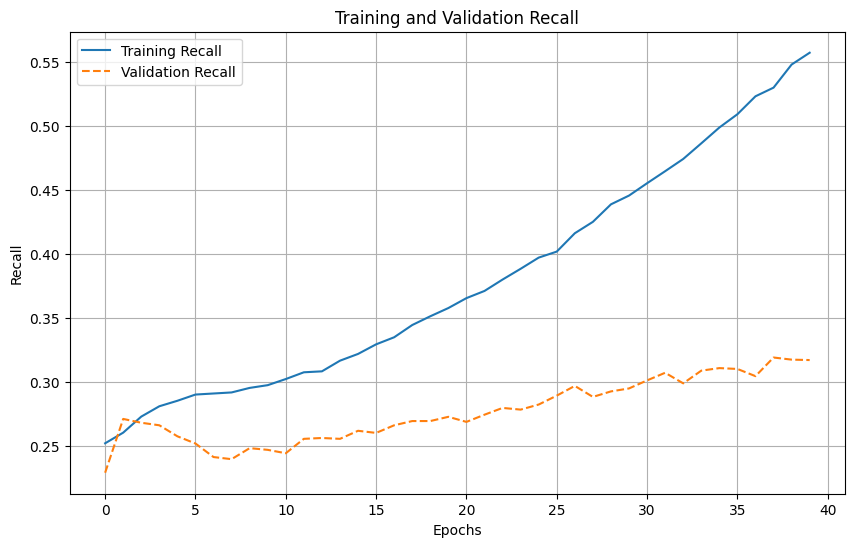

In [ ]:
# CodeGrade Tag Ex4a-i


# Extract metrics from the training history
history = cnn_history.history

# Print the available keys to check what metrics are tracked
print(history.keys())  # Check available keys in history

# Assuming the available keys are 'precision_1' and 'recall_1' (based on the typical names used in Keras)
# You can update these based on your `history.keys()` output if necessary.

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Precision (update key if needed)
plt.figure(figsize=(10, 6))
plt.plot(history['precision'], label='Training Precision')  # Use 'precision_1' if that's the key
plt.plot(history['val_precision'], label='Validation Precision', linestyle='--')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(history['recall'], label='Training Recall')
plt.plot(history['val_recall'], label='Validation Recall', linestyle='--')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

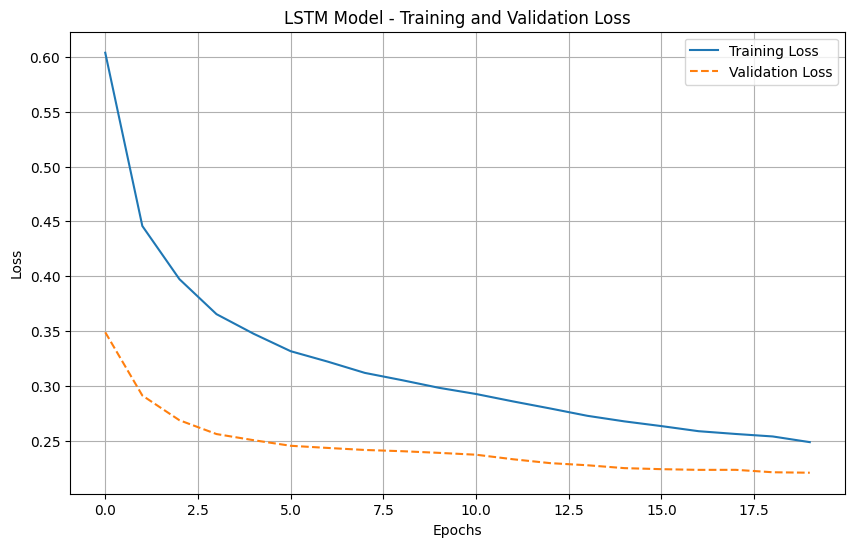

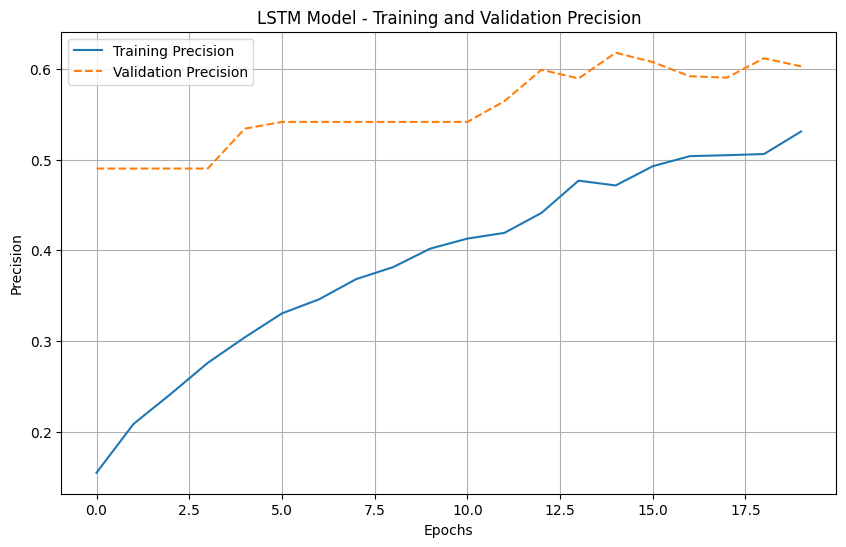

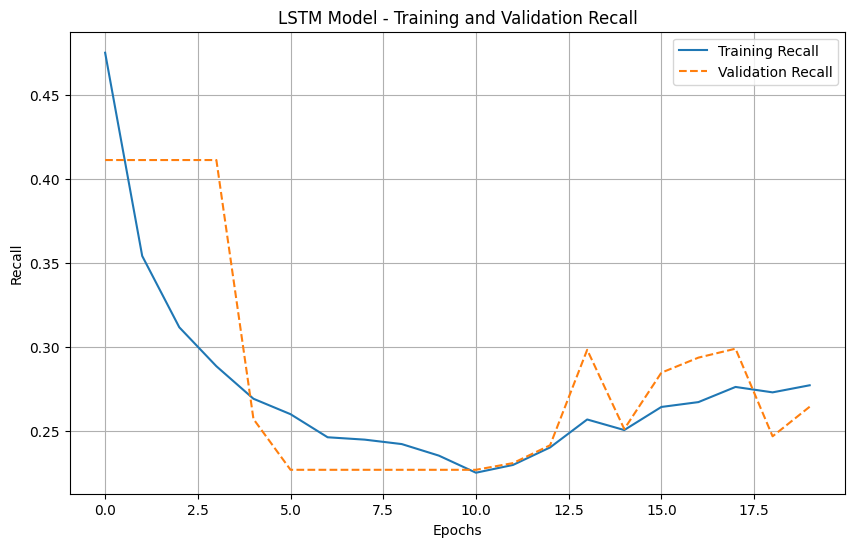

10/20 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step   

In [ ]:
# CodeGrade Tag Ex4b-i

# Load the best weights from the model checkpoint
lstm_model.load_weights('/content/checkpoint_lstm.weights.h5')

# Extract metrics from the training history
history = lstm_history.history

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Model - Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Precision
plt.figure(figsize=(10, 6))
plt.plot(history['precision'], label='Training Precision')
plt.plot(history['val_precision'], label='Validation Precision', linestyle='--')
plt.title('LSTM Model - Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Recall
plt.figure(figsize=(10, 6))
plt.plot(history['recall'], label='Training Recall')
plt.plot(history['val_recall'], label='Validation Recall', linestyle='--')
plt.title('LSTM Model - Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# Demonstrate classification performance for genres
# Predict using the validation dataset
predictions = lstm_model.predict(overviews_valid_ds)

# Plot the classification performance for three example classes
num_classes_to_plot = 3  # Adjust as necessary
plt.figure(figsize=(10, 6))
for i in range(num_classes_to_plot):
    plt.plot(predictions[:, i], label=f'Class {i+1} Predictions')
plt.title('LSTM Model - Classification Performance (Sample Classes)')
plt.xlabel('Samples')
plt.ylabel('Prediction Score')
plt.legend()
plt.grid(True)
plt.show()


### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

Loaded CNN model weights from /content/checkpoint_cnn.weights.h5.
Loaded LSTM model weights from /content/checkpoint_lstm.weights.h5.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


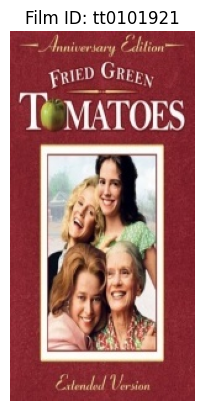

Overview: A housewife who is unhappy with her life befriends an old lady in a nursing home and is enthralled by the tales she tells of people she used to know.

Ground Truth Genres:
- Drama


Top 3 Predicted Genres (CNN):
- Comedy: 0.7812
- Adventure: 0.4655
- Drama: 0.3442


Top 3 Predicted Genres (LSTM):
- Drama: 0.3820
- Action: 0.3413
- Comedy: 0.3088

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


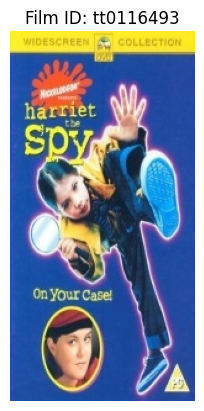

Overview: Harriet M. Welsch is a spy. But when her friends find her secret notebook the tables are turned on her. Can she win her friends back and still keep on going with the spy business?

Ground Truth Genres:
- Comedy
- Drama
- Family


Top 3 Predicted Genres (CNN):
- Comedy: 0.7565
- Drama: 0.3360
- Adventure: 0.3184


Top 3 Predicted Genres (LSTM):
- Drama: 0.4461
- Comedy: 0.3316
- Action: 0.2589

--------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


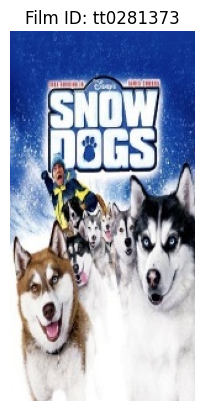

Overview: When a Miami dentist inherits a team of sled dogs, he's got to learn the trade or lose his pack to a crusty mountain man.

Ground Truth Genres:
- Adventure
- Comedy
- Family


Top 3 Predicted Genres (CNN):
- Comedy: 0.6569
- Romance: 0.5242
- Drama: 0.5145


Top 3 Predicted Genres (LSTM):
- Drama: 0.4949
- Comedy: 0.3834
- Crime: 0.2033

--------------------------------------------------



In [ ]:
# CodeGrade Tag Ex4c

# Load the model checkpoint weights for both CNN and LSTM
# Make sure that the checkpoints exist, and if not, print a message

# For CNN
cnn_checkpoint_path = '/content/checkpoint_cnn.weights.h5'
try:
    cnn_model.load_weights(cnn_checkpoint_path)
    print(f"Loaded CNN model weights from {cnn_checkpoint_path}.")
except FileNotFoundError:
    print(f"CNN model checkpoint not found at {cnn_checkpoint_path}. Using current weights.")

# For LSTM
lstm_checkpoint_path = '/content/checkpoint_lstm.weights.h5'
try:
    lstm_model.load_weights(lstm_checkpoint_path)
    print(f"Loaded LSTM model weights from {lstm_checkpoint_path}.")
except FileNotFoundError:
    print(f"LSTM model checkpoint not found at {lstm_checkpoint_path}. Using current weights.")

# Select example films from the dataset
example_indices = [0, 1, 2]  # Select indices for examples
example_data = data_test.iloc[example_indices]  # Use examples from the test dataset

# Loop through each selected example
for idx, film in example_data.iterrows():
    film_id = film["Id"]
    overview = film["Overview"]
    true_genres = film.drop(["Id", "Overview", "Genre"]).to_numpy()  # Ground truth labels

    # CNN Predictions (using the resized poster)
    poster_path = f"/content/drive/MyDrive/Images/{film_id}.jpg"
    try:
        poster_image = plt.imread(poster_path)  # Load poster
        resized_image = tf.image.resize(poster_image, [64, 64])  # Resize to model input shape
        cnn_predictions = cnn_model.predict(np.expand_dims(resized_image / 255.0, axis=0))[0]
    except FileNotFoundError:
        print(f"Poster not found for Film ID: {film_id}")
        cnn_predictions = np.zeros(len(true_genres))  # Default to zeros if poster is missing

    # LSTM Predictions
    tokenized_overview = vectorizer([overview])  # Tokenize the overview
    lstm_predictions = lstm_model.predict(tokenized_overview)[0]

    # Plot the poster (if available)
    if os.path.exists(poster_path):
        plt.imshow(poster_image)
        plt.axis("off")
        plt.title(f"Film ID: {film_id}")
        plt.show()
    else:
        print(f"Poster not available for Film ID: {film_id}")

    # Print the overview
    print(f"Overview: {overview}\n")

    # Display ground truth genres
    print("Ground Truth Genres:")
    true_genre_names = [genres[i] for i in np.where(true_genres > 0)[0]]
    for genre in true_genre_names:
        print(f"- {genre}")
    print("\n")

    # Display top 3 predictions for CNN
    print("Top 3 Predicted Genres (CNN):")
    top_cnn_indices = np.argsort(cnn_predictions)[-3:][::-1]
    for i in top_cnn_indices:
        print(f"- {genres[i]}: {cnn_predictions[i]:.4f}")
    print("\n")

    # Display top 3 predictions for LSTM
    print("Top 3 Predicted Genres (LSTM):")
    top_lstm_indices = np.argsort(lstm_predictions)[-3:][::-1]
    for i in top_lstm_indices:
        print(f"- {genres[i]}: {lstm_predictions[i]:.4f}")
    print("\n" + "-" * 50 + "\n")
